In [ ]:
# possible derived variables
# aspect - would determine insolation
# slope - may determine where avalanche chutes are that would take out trees
# also determine areas near the hydrography already downloaded to do detailed overlay
# Blue spruce is found on gentle upland and subirrigated slopes, in well-watered tributary drainages, 
# extending down intermittent streams, and on lower northerly slopes

%store

Stored variables and their in-db values:
band_dict                                   -> {'aerosol': <xarray.DataArray (y: 447, x: 504)> Si
boulder_areawater_gdf                       ->      ANSICODE       HYDROID          FULLNAME  MTF
boulder_gdf                                 ->     STATEFP COUNTYFP  COUNTYNS  GEOID         GEOI
boulder_linearwater_gdf                     ->      ANSICODE      LINEARID            FULLNAME AR
data_dir                                    -> 'C:\\Users\\gpaul\\earth-analytics\\data\\redlinin
denver_aoi_gdf                              ->       area_id    city state  city_surve           
denver_merged_das                           -> {'red': <xarray.DataArray (y: 599, x: 533)> Size: 
denver_ndmi_da                              -> <xarray.DataArray (y: 447, x: 504)> Size: 901kB
ar
denver_ndvi_da                              -> <xarray.DataArray (y: 447, x: 504)> Size: 901kB
ar
denver_proj_aoi_gdf                         ->       area_id    city state  c

C:\Users\gpaul\AppData\Local\Temp\ipykernel_23284\664420775.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]


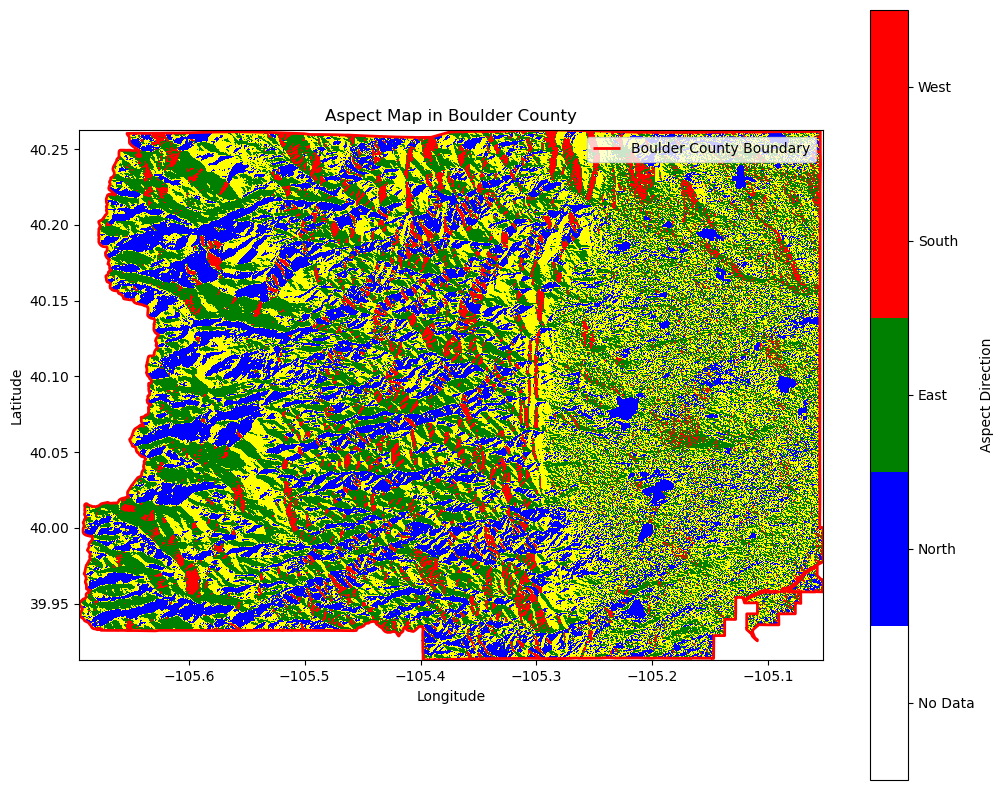

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib.colors import ListedColormap

# Load the Boulder County shapefile
boulder_gdf = gpd.read_file("./boulder_county.shp")

# Filepath to the DEM file (replace with your DEM source file path)
dem_filepath = "./dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif"

# Open the DEM file
with rasterio.open(dem_filepath) as src:
    # Reproject Boulder County boundary to the DEM CRS
    dem_crs = src.crs  # CRS of the DEM
    boulder_reproject_gdf = boulder_gdf.to_crs(dem_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the DEM to only include data within Boulder County
    dem_data, out_transform = mask(src, boulder_geometry, crop=True)
    dem_data = dem_data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": dem_data.shape[0],
            "width": dem_data.shape[1],
            "transform": out_transform,
        }
    )

# Replace no-data values (if any) with NaN
nodata_value = meta.get("nodata", None)
if nodata_value is not None:
    dem_data = np.where(dem_data == nodata_value, np.nan, dem_data)

# Compute aspect using numpy gradient
x, y = np.gradient(dem_data, axis=(1, 0))  # Gradient in x and y directions
aspect = (np.arctan2(-x, y) * 180 / np.pi) % 360  # Compute aspect in degrees

# Define aspect ranges for North, East, South, West
north_mask = (aspect >= 315) | (aspect < 45)
east_mask = (aspect >= 45) & (aspect < 135)
south_mask = (aspect >= 135) & (aspect < 225)
west_mask = (aspect >= 225) & (aspect < 315)

# Create a new array for highlighting
aspect_map = np.zeros_like(aspect, dtype=int)
aspect_map[north_mask] = 1  # North
aspect_map[east_mask] = 2  # East
aspect_map[south_mask] = 3  # South
aspect_map[west_mask] = 4  # West

# Define a custom colormap
colors = ["white", "blue", "yellow", "green", "red"]  # white for 0 (no aspect)
custom_cmap = ListedColormap(colors)

# Plot the DEM data with highlighted aspects
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the aspect map
highlight_img = ax.imshow(
    aspect_map,
    cmap=custom_cmap,
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * dem_data.shape[1],
        out_transform[5] + out_transform[4] * dem_data.shape[0],
        out_transform[5],
    ),
    origin="upper",
)

# Plot Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add labels, colorbar, and legend
cbar = plt.colorbar(highlight_img, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], boundaries=[0, 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(["No Data", "North", "East", "South", "West"])
cbar.set_label("Aspect Direction")
ax.legend()
plt.title("Aspect Map in Boulder County")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
# define gentle slopes 
# USDA Flat 0-3%
# USDA Undulating 3-8%
# USDA Moderately sloping 8-15%  Many mentions, but have not found original source yete

# Soil survey data provide another source of information about slopes. Soil mapping units are assigned a
# slope class to convey the dominant range of slope gradients occurring within the unit. The slope class is
# represented as a capital letter (from A to F) at the end of the mapping unit symbol. Although the slope
# ranges may vary, the general meaning is:
#  A – Nearly level (0-3%)
#  B – Gently sloping or undulating (1-8%)
#  C – Strongly sloping or rolling (4-16%)
#  D – Moderately steep or hilly (10-30%)
#  E – Steep (20-60%)
#  F – Very steep (greater than 45%) 
# https://www.stcplanning.org/wp-content/uploads/2021/07/DeterminingSlope.pdf

# for the blue spruce 0-8% looks appropriate

# stream classifications https://directives.nrcs.usda.gov/sites/default/files2/1712931124/7381.pdf

C:\Users\gpaul\AppData\Local\Temp\ipykernel_23284\1438277063.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]


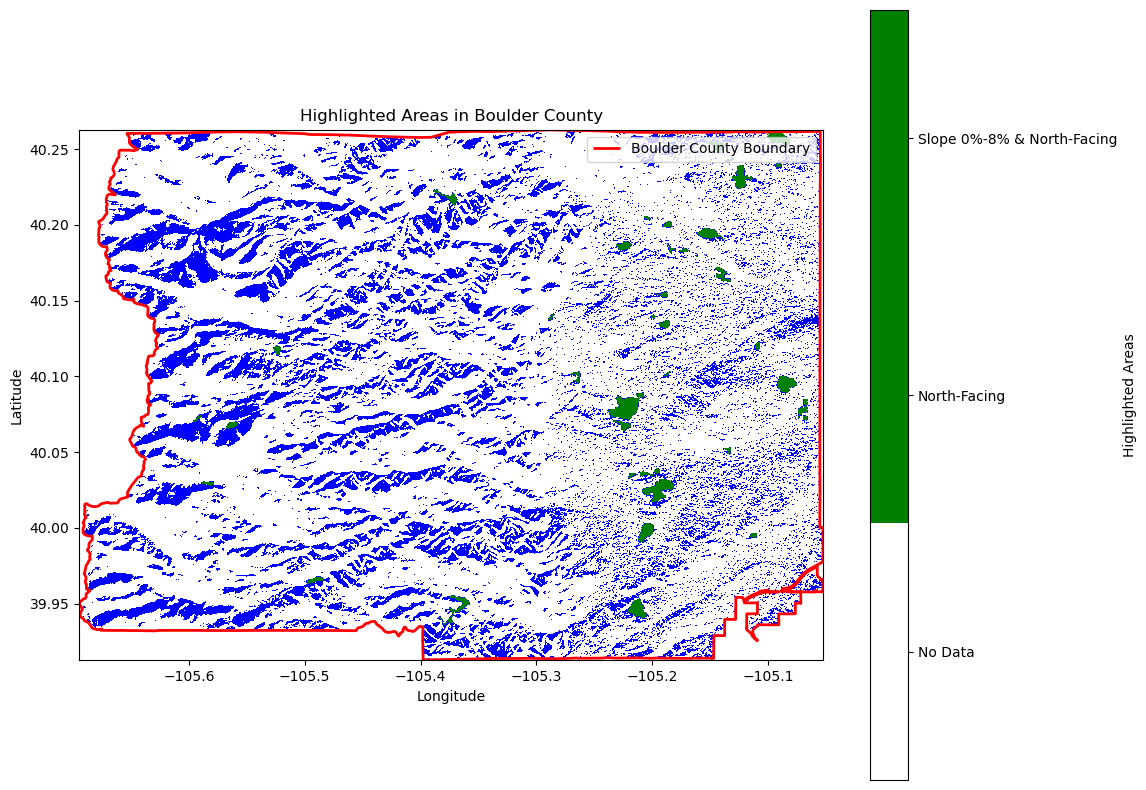

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib.colors import ListedColormap

# Load the Boulder County shapefile
boulder_gdf = gpd.read_file("./boulder_county.shp")

# Filepath to the DEM file
dem_filepath = "./dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif"

# Open the DEM file
with rasterio.open(dem_filepath) as src:
    # Reproject Boulder County boundary to the DEM CRS
    dem_crs = src.crs  # CRS of the DEM
    boulder_reproject_gdf = boulder_gdf.to_crs(dem_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the DEM to only include data within Boulder County
    dem_data, out_transform = mask(src, boulder_geometry, crop=True)
    dem_data = dem_data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": dem_data.shape[0],
            "width": dem_data.shape[1],
            "transform": out_transform,
        }
    )

# Replace no-data values (if any) with NaN
nodata_value = meta.get("nodata", None)
if nodata_value is not None:
    dem_data = np.where(dem_data == nodata_value, np.nan, dem_data)

# Compute slope in percent
x, y = np.gradient(dem_data, axis=(1, 0))  # Gradient in x and y directions
slope = np.sqrt(x**2 + y**2) * 100  # Slope in percent

# Compute aspect
aspect = (np.arctan2(-x, y) * 180 / np.pi) % 360  # Compute aspect in degrees

# Define masks
north_mask = (aspect >= 315) | (aspect < 45)  # North-facing aspects
slope_mask = (slope >= 0) & (slope <= 8)  # Slope between 0% and 8%
combined_mask = north_mask & slope_mask  # Areas that meet both criteria

# Highlight data: 0 for no highlight, 1 for north-facing areas, 2 for combined
highlighted_map = np.zeros_like(dem_data, dtype=int)
highlighted_map[north_mask] = 1  # North-facing areas
highlighted_map[combined_mask] = 2  # Areas meeting both conditions

# Define a custom colormap
colors = ["white", "blue", "green"]  # White for no data, blue for north-facing, green for combined
custom_cmap = ListedColormap(colors)

# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the highlighted map
highlight_img = ax.imshow(
    highlighted_map,
    cmap=custom_cmap,
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * dem_data.shape[1],
        out_transform[5] + out_transform[4] * dem_data.shape[0],
        out_transform[5],
    ),
    origin="upper",
)

# Plot Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add labels, colorbar, and legend
cbar = plt.colorbar(highlight_img, ax=ax, ticks=[0.5, 1.5, 2.5], boundaries=[0, 1, 2, 3])
cbar.ax.set_yticklabels(["No Data", "North-Facing", "Slope 0%-8% & North-Facing"])
cbar.set_label("Highlighted Areas")
ax.legend()
plt.title("Highlighted Areas in Boulder County")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


C:\Users\gpaul\AppData\Local\Temp\ipykernel_23284\3144323234.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]


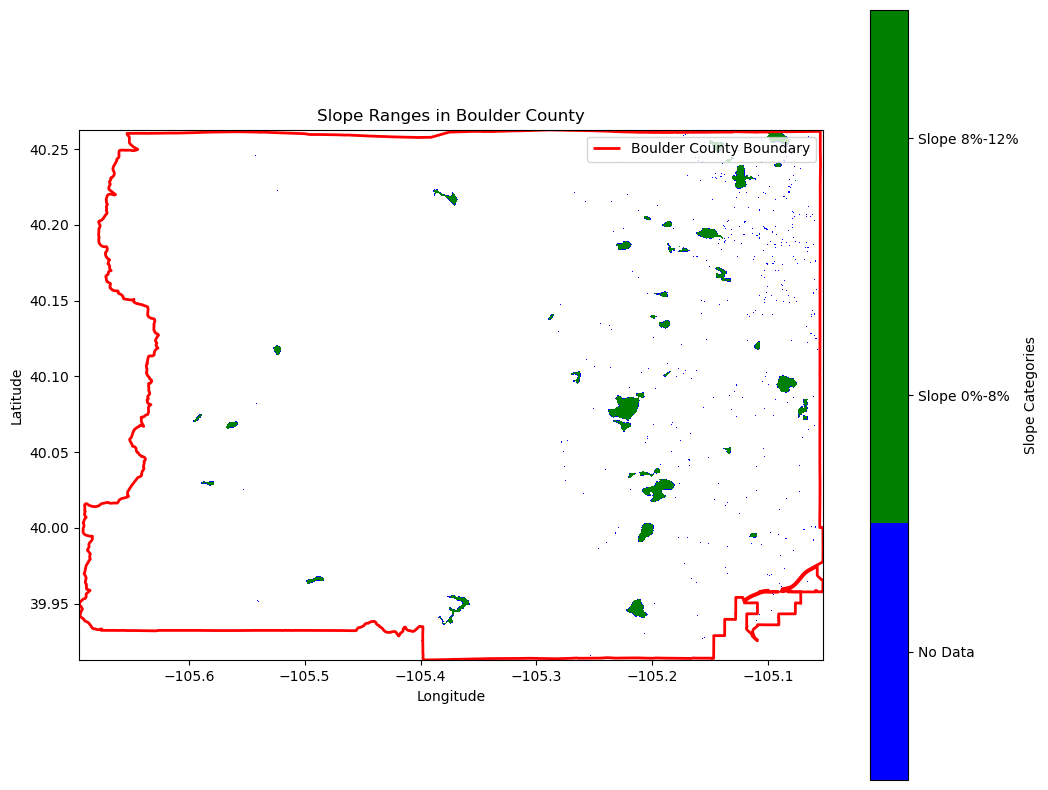

In [5]:
# show just areas that are 0-8% and 8-12% slope

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib.colors import ListedColormap

# Load the Boulder County shapefile
boulder_gdf = gpd.read_file("./boulder_county.shp")

# Filepath to the DEM file
dem_filepath = "./dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif"

# Open the DEM file
with rasterio.open(dem_filepath) as src:
    # Reproject Boulder County boundary to the DEM CRS
    dem_crs = src.crs  # CRS of the DEM
    boulder_reproject_gdf = boulder_gdf.to_crs(dem_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the DEM to only include data within Boulder County
    dem_data, out_transform = mask(src, boulder_geometry, crop=True)
    dem_data = dem_data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": dem_data.shape[0],
            "width": dem_data.shape[1],
            "transform": out_transform,
        }
    )

# Replace no-data values (if any) with NaN
nodata_value = meta.get("nodata", None)
if nodata_value is not None:
    dem_data = np.where(dem_data == nodata_value, np.nan, dem_data)

# Compute slope in percent
x, y = np.gradient(dem_data, axis=(1, 0))  # Gradient in x and y directions
slope = np.sqrt(x**2 + y**2) * 100  # Slope in percent

# Define slope masks
slope_0_8_mask = (slope >= 0) & (slope <= 8)  # Slopes 0%-8%
slope_8_12_mask = (slope > 8) & (slope <= 12)  # Slopes 8%-12%

# Highlight data: 0 for no highlight, 1 for 0%-8%, 2 for 8%-12%
highlighted_map = np.zeros_like(dem_data, dtype=int)
highlighted_map[slope_0_8_mask] = 1
highlighted_map[slope_8_12_mask] = 2

# Define a custom colormap
colors = ["white", "blue", "green"]  # White for no data, blue for 0%-8%, green for 8%-12%
custom_cmap = ListedColormap(colors)

# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the highlighted map
highlight_img = ax.imshow(
    highlighted_map,
    cmap=custom_cmap,
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * dem_data.shape[1],
        out_transform[5] + out_transform[4] * dem_data.shape[0],
        out_transform[5],
    ),
    origin="upper",
)

# Plot Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add labels, colorbar, and legend
cbar = plt.colorbar(highlight_img, ax=ax, ticks=[0.5, 1.5, 2.5], boundaries=[0, 1, 2, 3])
cbar.ax.set_yticklabels(["No Data", "Slope 0%-8%", "Slope 8%-12%"])
cbar.set_label("Slope Categories")
ax.legend()
plt.title("Slope Ranges in Boulder County")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
